In [38]:
!pip install wordcloud

In [39]:
!pip install shap

In [62]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import re
from scipy.stats import norm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import shap
from keras.callbacks import ModelCheckpoint

In [41]:
df = pd.read_excel ('/content/Reviews_example.xlsx')

In [42]:
df.head()

Stars                                               Date  \
0  5.0 out of 5 stars  Reviewed in the United States on February 4, 2022   
1  5.0 out of 5 stars  Reviewed in the United States on February 4, 2022   
2  5.0 out of 5 stars  Reviewed in the United States on February 4, 2022   
3  2.0 out of 5 stars  Reviewed in the United States on February 3, 2022   
4  5.0 out of 5 stars  Reviewed in the United States on February 1, 2022   

                                              Titles  \
0          Sony noise cancelling wireless headphones   
1                                   Best headphones!   
2  Life changing - these are great headphones esp...   
3                                      average sound   
4                                  Great headphones.   

                                             Reviews  
0  The sound is very good and the noise cancellin...  
1  The noise cancellation is amazing!! I wasnt ex...  
2  I don't do a lot of reviews. However, reading ...  
3  Not really the greatest sound, the bass is not...  
4                       Great product for the money.

In [43]:
# influence the titles (from 1 to 3)
i = 3

In [44]:
# class to preprocess the df
class DataPreprocessing:
    def __init__(self, df):
        self.df = df
        self.i = i
    #general format preparation
    def df_preparation (self, i):
      # make 	Stars numeracle
      self.df.replace({
        '1.0 out of 5 stars': 1,
        '2.0 out of 5 stars': 2,
        '3.0 out of 5 stars': 3,
        '4.0 out of 5 stars': 4,
        '5.0 out of 5 stars': 5
      }, inplace=True)
      # creating combined colunm by combining Titles with i coef and Reviews
      self.df['combined'] = df.apply(lambda row: (row['Titles'] + ' ') * i + row['Reviews'], axis=1)
      self.df.drop (['Date', 'Titles', 'Reviews'], axis = 1, inplace=True)
      return self.df.head()
    # text preparation in combined column
    def clean_text (self):
    # lower register
      self.df['combined'] = self.df['combined'].str.lower()
      # Removing punctuation using regular expressions
      self.df['combined'] = self.df['combined'].str.replace(r'[^\w\s]', '', regex=True)
      # Deleting stopwords
      stopwords = set(STOPWORDS)
      self.df['combined'] = self.df['combined'].apply(lambda text: ' '.join([word for word in text.split() if word not in stopwords]))
      return self.df['combined']
    def process_data(self, i):
        self.df_preparation(i)
        self.clean_text()
        return self.df.head()

In [45]:
#class initialize
prepro = DataPreprocessing(df)

In [46]:
prepro.process_data(i)

<ipython-input-44-4ca36dce79a5>:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  self.df.replace({


Stars                                           combined
0      5  sony noise cancelling wireless headphones sony...
1      5  best headphones best headphones best headphone...
2      5  life changing great headphones esp price point...
3      2  average sound average sound average sound real...
4      5  great headphones great headphones great headph...

# **1. Statistical analysis**

## **1.1 Stars analysis**

In [47]:
df.Stars.describe()

count    990.000000
mean       4.255556
std        1.131561
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000
Name: Stars, dtype: float64

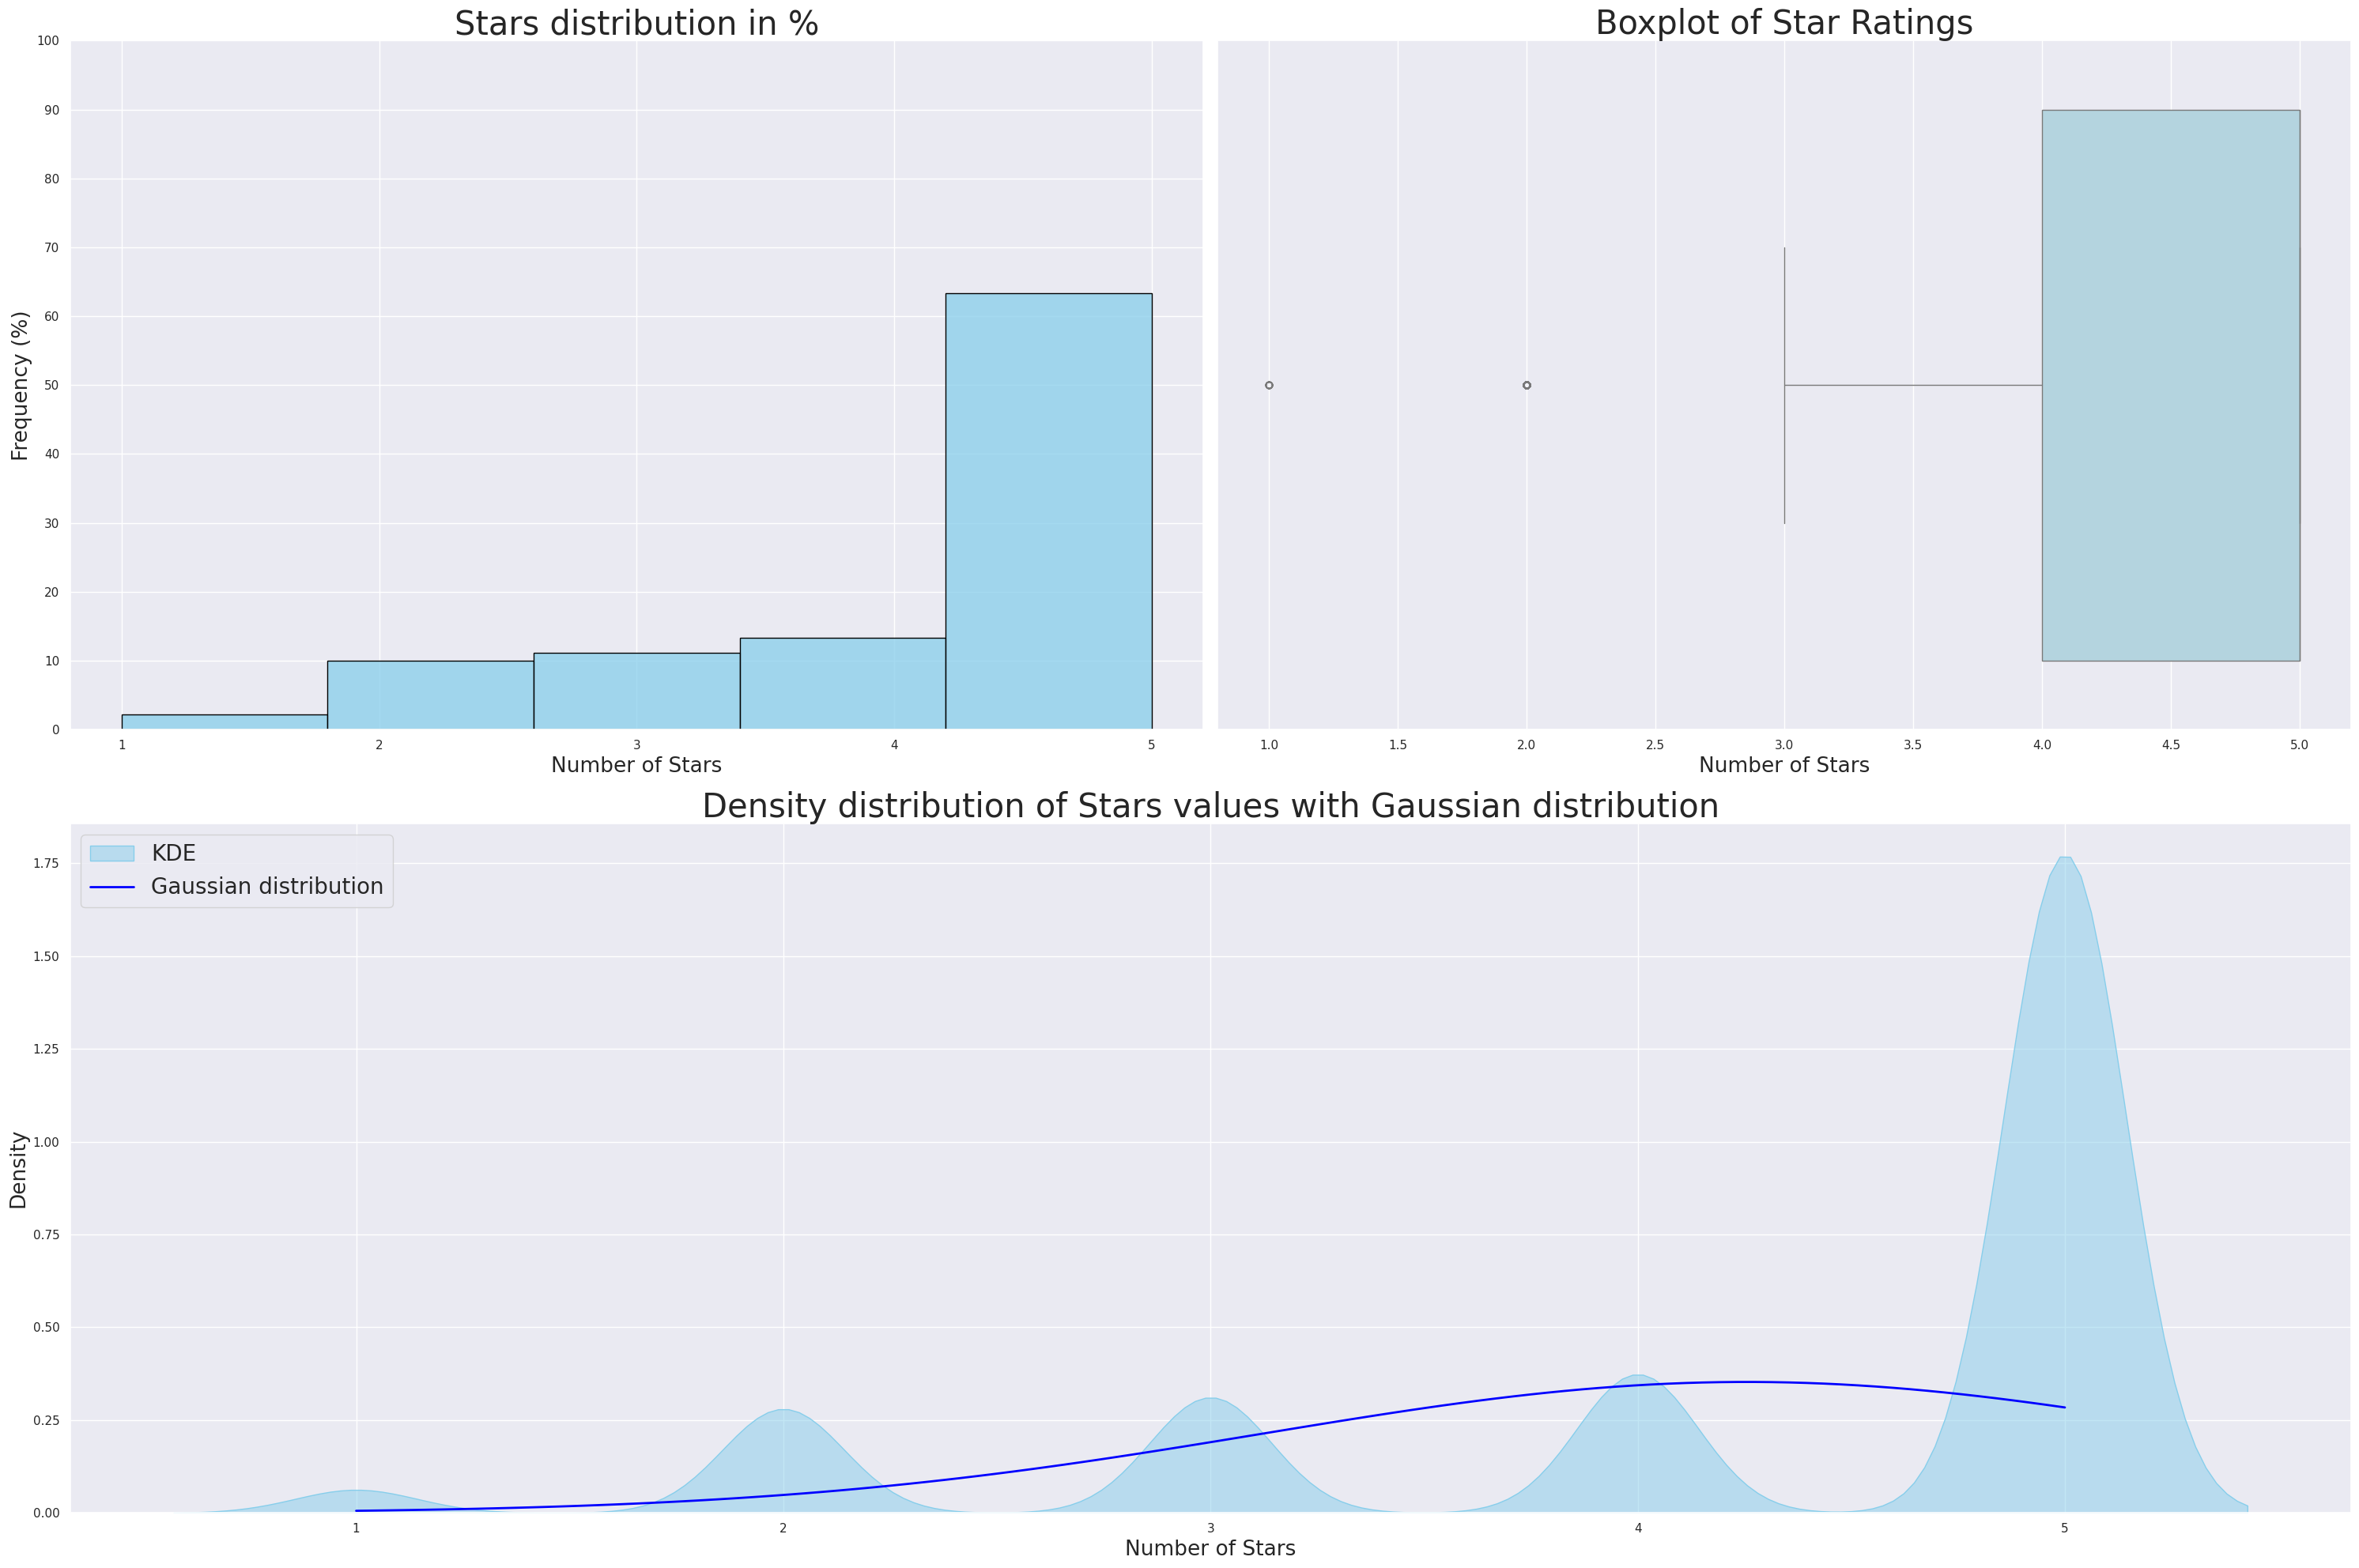

In [48]:
sns.set(style="darkgrid")
fig = plt.figure(figsize=(30, 20))
gs = fig.add_gridspec(2, 2)

# 1. histogram
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(df['Stars'], bins=5, stat='percent', color='skyblue', edgecolor='black', ax=ax1)
ax1.set_title('Stars distribution in %', fontsize=30)
ax1.set_xlabel('Number of Stars', fontsize=19)
ax1.set_ylabel('Frequency (%)', fontsize=19)
ax1.set_xticks([1, 2, 3, 4, 5])
ax1.set_yticks(range(0, 101, 10))

# 2. Boxplot
ax2 = fig.add_subplot(gs[0, 1])
sns.boxplot(x='Stars', data=df, color='lightblue', ax=ax2)
ax2.set_title('Boxplot of Star Ratings', fontsize=30)
ax2.set_xlabel('Number of Stars', fontsize=19)

# 3. Density Distribution (KDE)
mean = np.mean(df['Stars'])
std_dev = np.std(df['Stars'])

x = np.linspace(1, 5, 100)
y = norm.pdf(x, mean, std_dev)

# KDE
ax3 = fig.add_subplot(gs[1, :])
mean = np.mean(df['Stars'])
std_dev = np.std(df['Stars'])
x = np.linspace(1, 5, 100)
y = norm.pdf(x, mean, std_dev)


sns.kdeplot(df['Stars'], bw_adjust=0.5, fill=True, color='skyblue', alpha=0.5, ax=ax3, label='KDE')
ax3.set_title('Density distribution of Stars values ​​with Gaussian distribution', fontsize=30)
ax3.set_xlabel('Number of Stars', fontsize=19)
ax3.set_ylabel('Density', fontsize=19)
ax3.set_xticks([1, 2, 3, 4, 5])
ax3.plot(x, y, color='blue', label='Gaussian distribution', linewidth=2)
ax3.legend(loc='upper left', fontsize=20)

plt.tight_layout()
plt.show()

## **1.2 Word clouds for different stars reviews**

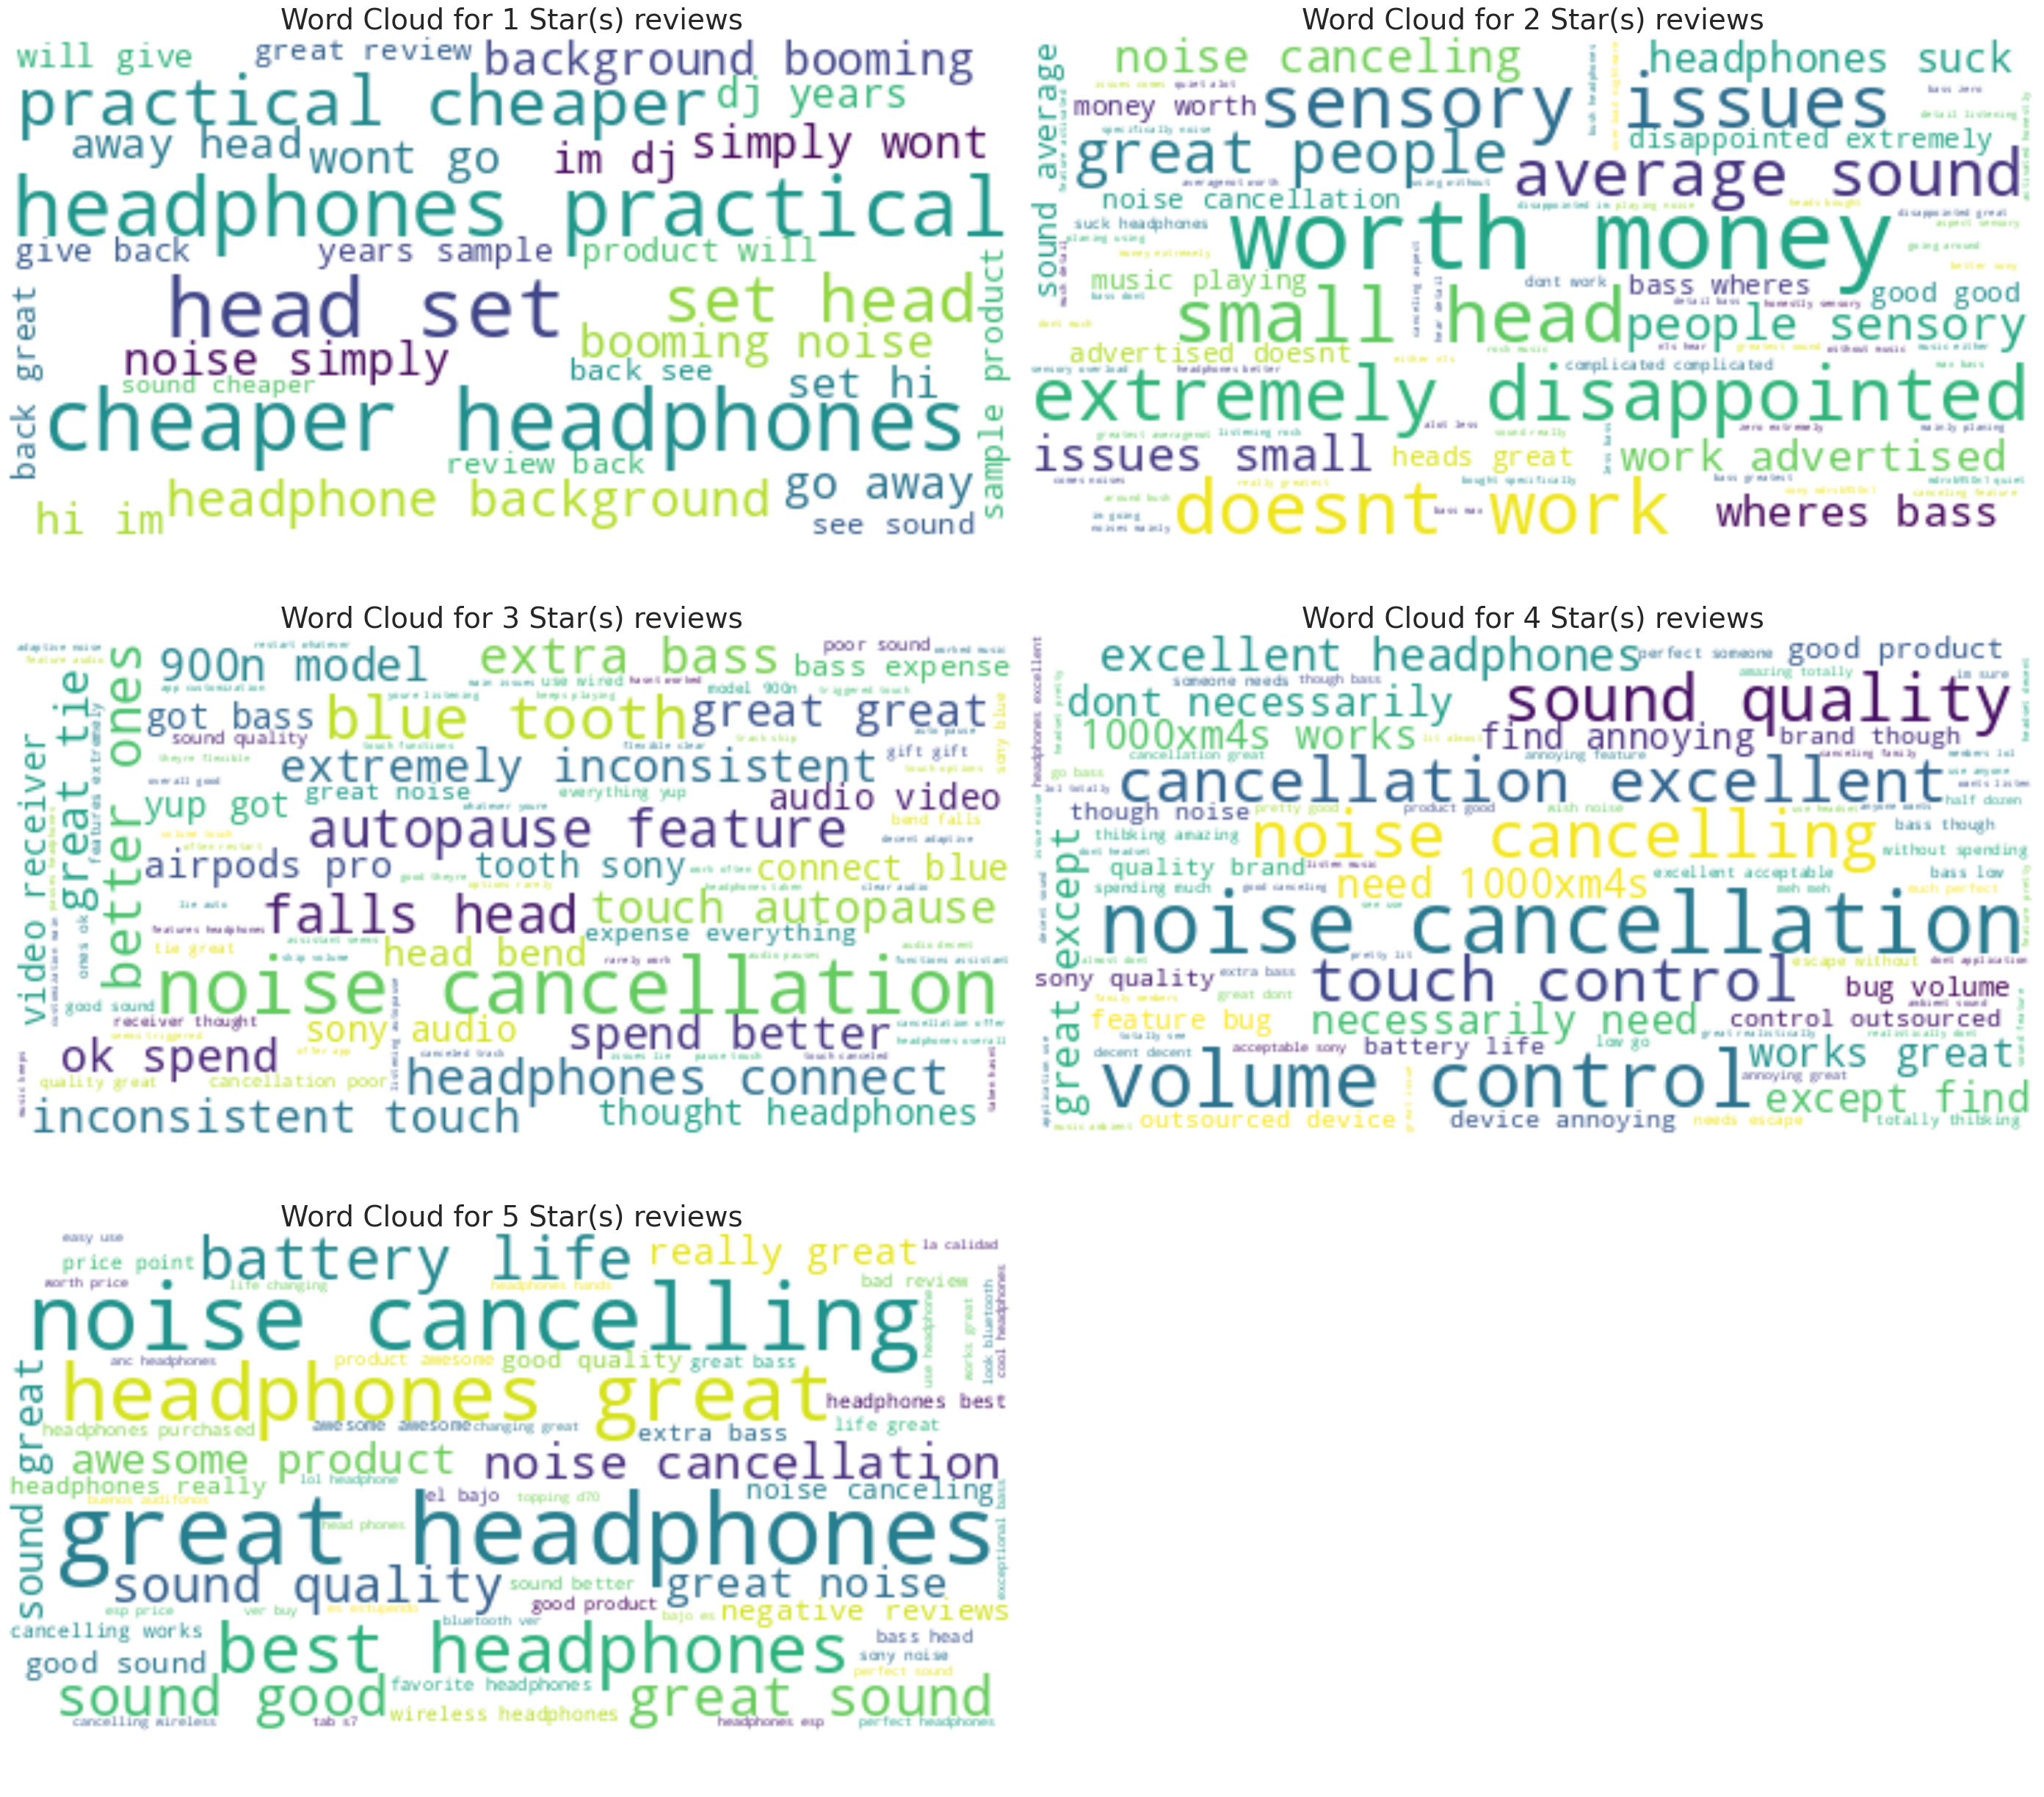

In [49]:
wc = WordCloud(background_color='white', max_words=2000, contour_width=3, contour_color='steelblue')

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(28, 25))
axes = axes.flatten()

for a in range(1, 6):
    text = ' '.join(df.query(f"Stars == {a}")['combined'].astype(str))
    wc.generate(text)
    axes[a - 1].imshow(wc, interpolation='bilinear')
    axes[a - 1].axis('off')
    axes[a - 1].set_title(f"Word Cloud for {a} Star(s) reviews", fontsize=28)

axes[5].axis('off')

plt.tight_layout()
plt.show()

# **2. Sentiment_analysis**

## **2.1 Vocabulary generation**

In [50]:
df['Stars'] = df['Stars'] - 1

In [51]:
tokenizer = Tokenizer (num_words= 5000, oov_token= '<OOV>')
tokenizer.fit_on_texts (df['combined'])
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(df['combined'])
max_length = 300
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences,
    df['Stars'],
    test_size=0.2,
    random_state=42
)

In [53]:
vocab_size = len(word_index) + 1
embedding_dim = 128

## **2.2 Neural network design**

In [54]:
model = tf.keras.Sequential([
  tf.keras.layers.Embedding(input_dim=vocab_size,
                            output_dim=embedding_dim,
                            input_length=max_length),
  tf.keras.layers.LSTM(128, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.GlobalMaxPooling1D(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(1, activation='linear')
  ])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [55]:
model.compile(loss='mean_squared_error',
              optimizer='Adam',
              metrics=['mae'])

In [68]:
checkpoint_path = "best_model.keras"

In [69]:
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_mal',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [56]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_data=(X_test, y_test),
    batch_size=32
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 38s 954ms/step - loss: 7.0428 - mae: 2.3188 - val_loss: 1.2859 - val_mae: 0.9776
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 826ms/step - loss: 2.2131 - mae: 1.2201 - val_loss: 1.1887 - val_mae: 0.9072
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - loss: 1.9290 - mae: 1.1388 - val_loss: 0.7525 - val_mae: 0.7504
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 893ms/step - loss: 1.3616 - mae: 0.9365 - val_loss: 0.5632 - val_mae: 0.6938
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 898ms/step - loss: 1.1068 - mae: 0.8557 - val_loss: 0.4072 - val_mae: 0.5650
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - loss: 1.1444 - mae: 0.8636 - val_loss: 0.3251 - val_mae: 0.3609
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 1.0049 - mae: 0.8147 - val_loss: 0.3328 - val_mae: 0.4885
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - loss: 0.8856 - mae: 0.7548 - val_loss: 0.0995 - val_mae: 0.2439
Epoch 9/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - loss: 0.

## **2.3 Sentimential analysis**

In [70]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]

word_weights = {}
for word, index in tokenizer.word_index.items():
    if index < vocab_size:
        word_weights[word] = np.linalg.norm(weights[index])

word_weights_df = pd.DataFrame(word_weights.items(), columns=['Word', 'Weight'])
word_weights_df = word_weights_df.sort_values(by='Weight', ascending=False)

In [71]:
mean_weight = word_weights_df['Weight'].mean()
word_weights_df['Weight'] = word_weights_df['Weight'] - mean_weight

In [72]:
word_weights_df.to_excel('word_influence.xlsx', index=False)

In [73]:
top_25_best = word_weights_df.head(25)
top_25_worst = word_weights_df.tail(25)
combined_df = pd.concat([top_25_best, top_25_worst])

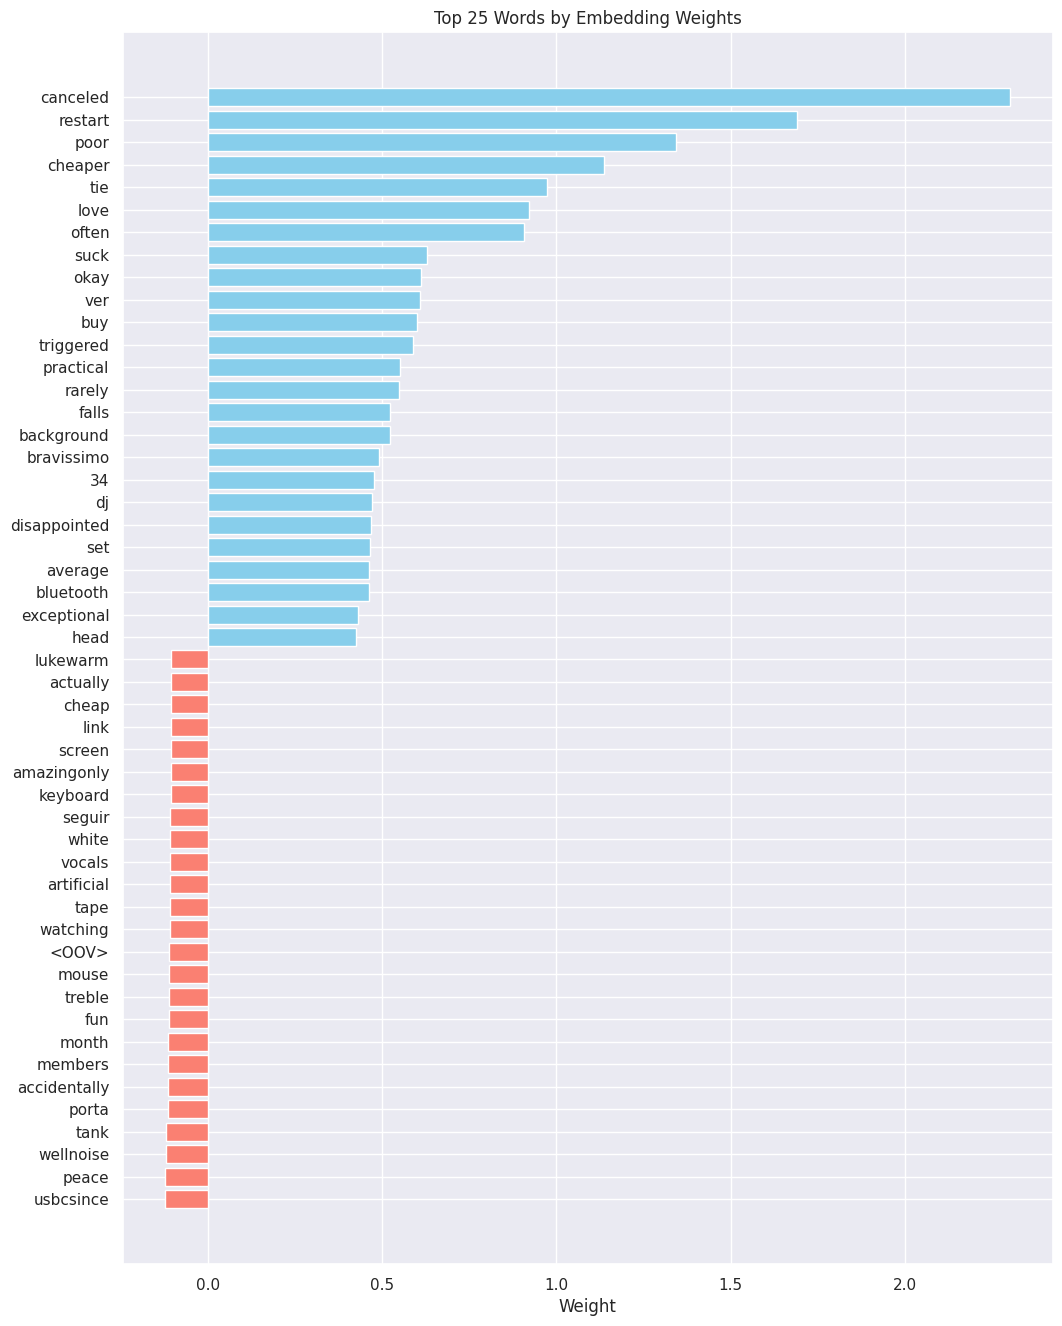

In [74]:
plt.figure(figsize=(12, 16))
plt.barh(combined_df['Word'], combined_df['Weight'], color=['skyblue' if weight > 0 else 'salmon' for weight in combined_df['Weight']])
plt.xlabel('Weight')
plt.title('Top 25 Words by Embedding Weights')
plt.gca().invert_yaxis()
plt.show()

# **Conclusion**

**Positive Features:**
1. Sound Clarity: The headphones provide clear and crisp sound, highlighted by the word "canceled" (2.30), which suggests effective cancellation of unwanted noise and background sounds.
2. Comfort: They are comfortable to wear, as indicated by words like "love" (0.92) and "often" (0.91), suggesting that users enjoy wearing them for extended periods.
3. Affordability: The word "cheaper" (1.13) implies that these headphones may be more accessible in price compared to competitors while still maintaining high quality.
4. Functionality: They come with various features that enhance usability, emphasized by the word "practical" (0.55).
**Negative Features:**
1. Build Quality: Some words, such as "link" (-0.11) and "screen" (-0.10), may indicate potential drawbacks related to functionality, such as connectivity issues with devices.
2. Noise Cancellation: The word "artificial" (-0.10) might suggest that the noise-canceling technology doesn't always perform as expected, creating an "artificial" sound experience.
3. Lack of Certain Features: Words like "accidentally" (-0.11) and "peace" (-0.12) could indicate potential issues with usability, such as accidental disconnections or insufficient isolation from external sounds.

These headphones represent an excellent blend of sound quality and comfort, making them a great choice for everyday use. However, there some problem with noice cancelation and sounds. General ration is good